# Plots for goal-scoring shots

In [108]:
import database
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [3]:
db = database.DataBase()
def get_dataframe(sql):
    db.crs.execute(sql)
    data = db.crs.fetchall()
    extracted_columns = list(zip(*db.crs.description))[0]
    frame = pd.DataFrame(data,columns=extracted_columns)
    return frame

### Goals by category

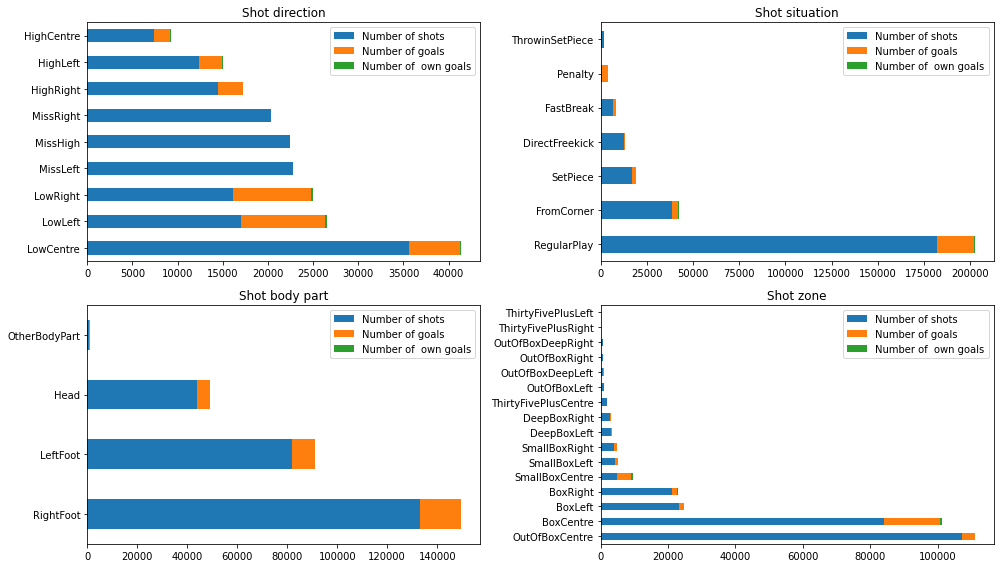

In [4]:
def plot_single_category(category,title,ax=None):
    sql = f'SELECT text as {category}, count(if(not isGoal and not isOwnGoal,1,NULL)) as "Number of shots", count(if(isGoal and not isOwnGoal,1,NULL)) as "Number of goals", count(if(isOwnGoal,1,NULL)) as "Number of  own goals" FROM football.event_shots join descriptors on {category}=descriptor_id group by text;'
    frame = get_dataframe(sql)
    frame.set_index(frame.columns[0], inplace=True)
    frame['sum'] = frame.sum(axis=1)
    frame.sort_values('sum', inplace = True, ascending = False)
    del frame['sum']
    plot = frame.plot.barh(ax=ax,stacked=True,title = title, xlabel='')

fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(14,8),tight_layout=True)
plot_single_category('shotDirection', 'Shot direction',ax=axes[0,0])
plot_single_category('shotSituation', 'Shot situation',ax=axes[0,1])
plot_single_category('shotBodyPart', 'Shot body part',ax=axes[1,0])
plot_single_category('shotZone', 'Shot zone',ax=axes[1,1])

### Goal-scoring shots

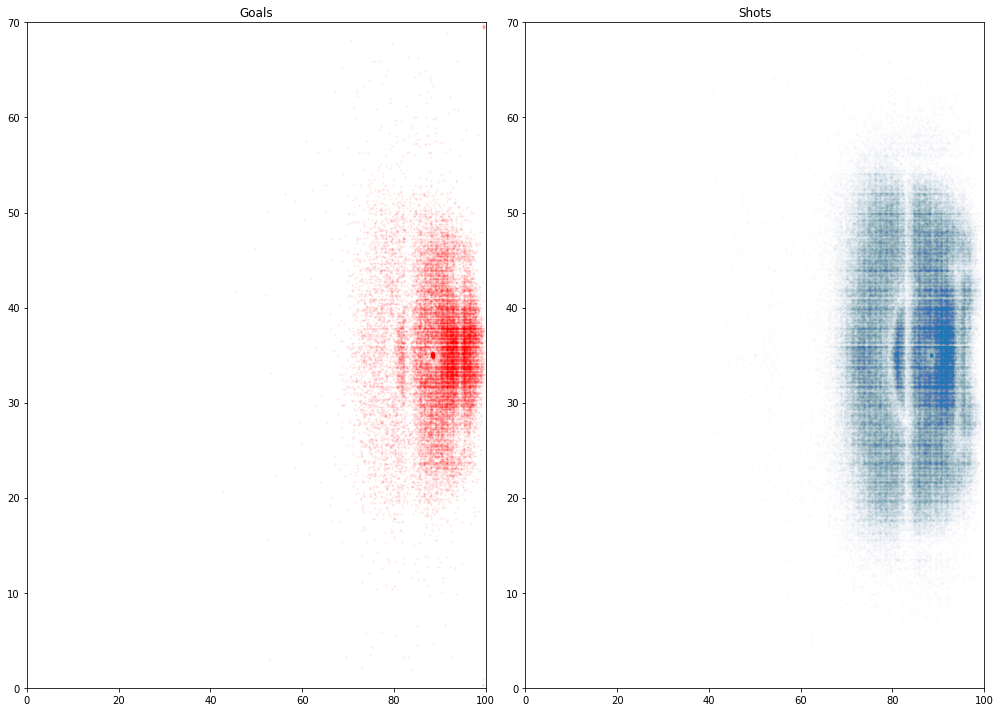

In [287]:
def plot_coords(sql,title,alpha=1,s=10,ax=None,c=None):
    frame = get_dataframe(sql)
    frame.plot.scatter(c=c,ax=ax,x=frame.columns[0],y=frame.columns[1],xlim=[0,100],ylim=[0,70],s=s,title=title,alpha=alpha,xlabel='',ylabel='')
    
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(14,10),tight_layout=True)
plot_coords('select shotX, shotY*0.7 from event_shots where isGoal and not isOwnGoal','Goals',alpha=0.05,ax=axes[0],s=2,c='red')
#plot_coords('select shotX, shotY*0.7 from event_shots where isOwnGoal','Own goals',alpha=0.03,ax=axes[1],s=30)
plot_coords('select shotX, shotY*0.7 from event_shots where not isGoal and not isOwnGoal','Shots',alpha=0.01,ax=axes[1],s=2)

### Ball crossing goalline

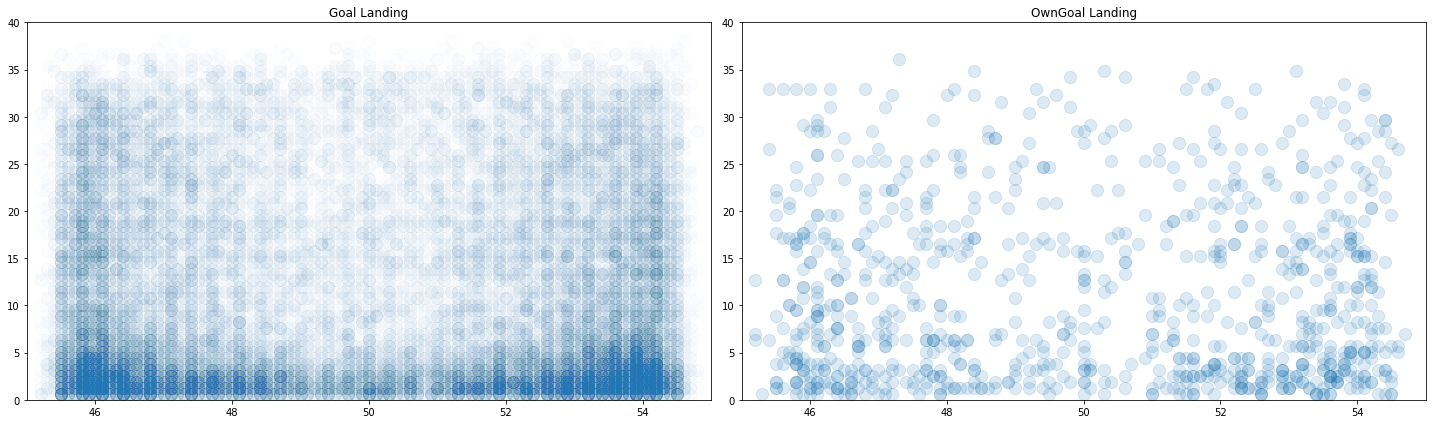

In [6]:
def plot_goalline_coords(sql,title,aplha=1,ax=None):
    frame = get_dataframe(sql)
    frame.plot.scatter(ax=ax,x=frame.columns[0],y=frame.columns[1],xlim=[45,55],ylim=[0,40],s=150,figsize=(20,6),title=title,alpha=aplha,xlabel='',ylabel='')

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(14,5),tight_layout=True)
plot_goalline_coords('select goalMouthY, goalMouthZ from event_shots where isGoal and not isOwnGoal', 'Goal Landing',aplha=0.01,ax=axes[0])
plot_goalline_coords('select goalMouthY, goalMouthZ from event_shots where isOwnGoal', 'OwnGoal Landing',aplha=0.15,ax=axes[1])

### Goal probability

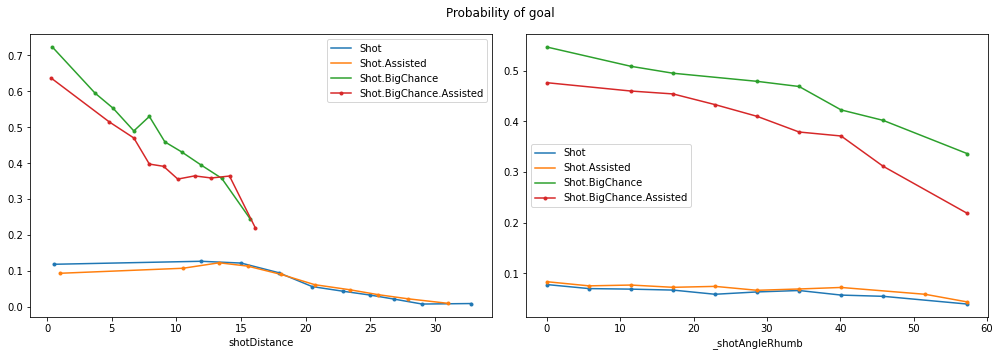

In [169]:
def probability_by_param(param, bins=10,ax=None, isBigChance=False,isAssisted=False,notOwn=True,notPenalty=True):
    sql = f'select isGoal, {param} from event_shots where not isBlocked and shotSituation = 22 '
    sql += ' and isBigChance ' if isBigChance else ' and not isBigChance '
    sql += ' and isAssisted ' if isAssisted else ' and not isAssisted '
    sql += ' and  _shotDx>0 ' if notOwn else ' _shotDx<0'
    sql += ' and shotSituation != 9 ' if notPenalty else ''
    frame = get_dataframe(sql)
    label = 'Shot' + ('.BigChance' if isBigChance else '')
    label += '.Assisted' if isAssisted else ''
    binned,bins = pd.qcut(frame[param], bins, retbins=True,duplicates='drop')
    grouped = frame[param].groupby(by=[binned,frame['isGoal']]).count()
    prob_of_goal_by_param = grouped[:,1] / grouped.groupby(param).sum()
    prob_of_goal_by_param.index = bins[:-1]
    prob_of_goal_by_param.plot(ax=ax,xlabel = param.split(' ')[0],label=label, style='.-',legend=True)

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(14,5),tight_layout=True)
fig.suptitle('Probability of goal')

probability_by_param('shotDistance', ax=axes[0])
probability_by_param('shotDistance', ax=axes[0], isAssisted=True)
probability_by_param('shotDistance', ax=axes[0], isBigChance=True)
probability_by_param('shotDistance', ax=axes[0], isAssisted=True, isBigChance=True)
probability_by_param('_shotAngleRhumb * 57.2958', ax=axes[1])
probability_by_param('_shotAngleRhumb * 57.2958', ax=axes[1], isAssisted=True)
probability_by_param('_shotAngleRhumb * 57.2958', ax=axes[1], isBigChance=True)
probability_by_param('_shotAngleRhumb * 57.2958', ax=axes[1], isAssisted=True, isBigChance=True)